In [14]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm 

from natorch.utils.data import train_test_split

from natorch.utils.io import save_hyper_params, save_model, load_model, load_params, clear_checkpoint

from natorch.nn.modules.losses import BCELoss
from natorch.optim import SGD, Adam

from natorch.nn.models import AutoEncoder

### Import Dataset

In [15]:
data_path = '../../../../../data/MNIST/MNIST.csv'
data = pd.read_csv(data_path)
data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Pre-processing

In [16]:
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()
X = X/255.0
X.shape, y.shape

((42000, 784), (42000,))

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
x_train.shape, y_train.shape

((33600, 784), (33600,))

In [18]:
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
x_train.shape, x_test.shape

((33600, 1, 28, 28), (8400, 1, 28, 28))

### Define model 

In [19]:
model = AutoEncoder(latent_dim=64, negative_slope=0.1)

Re-initialize parameters


In [20]:
load_model(model, save_dir = '../../../../../checkpoints/autoencoder', file_name = 'checkpoint_epoch_30')

In [21]:
def fit(x_train, epochs : int = 100, lr : float = 1e-3, batch_size : int = 32, checkpoint : bool = False, num_epochs_save : int = 1) :
    
    N = x_train.shape[0]
    loss_fn = BCELoss()
    # optimizer = SGD(model.net._parameter(), lr=lr)
    optimizer = Adam(model.net._parameter(), lr=lr)
    
    
    if checkpoint == True and os.path.exists('../../../../../checkpoints/autoencoder'):
            clear_checkpoint(save_dir = '../../../../../checkpoints/autoencoder')
            save_hyper_params(file_path='../../../../../checkpoints/autoencoder/hyper_params.json', epochs = epochs, lr = lr, batch_size = batch_size)
    
    for epoch in range(1, epochs + 1):
        perm = np.random.permutation(N)
        epoch_loss = 0.0
        
        for i in tqdm(range(0, N, batch_size), desc= f"Epoch [{epoch}/{epochs}]"):
            optimizer.zero_grad()
            idx = perm[i : i + batch_size]
            xb = x_train[idx]
            
            # Forward
            reconstructed_img = model.forward(xb)
            
            
            loss = loss_fn.forward(reconstructed_img, xb)
            epoch_loss += loss * xb.shape[0]

            # Backward
            grad_loss = loss_fn.backward()
            model.backward(grad_loss)
            
            # Update
            optimizer.step()
            
        if checkpoint == True and epoch % num_epochs_save == 0: 
            save_model(params=model.net._parameter(), save_dir='../../../../../checkpoints/autoencoder', file_name=f'checkpoint_epoch_{epoch}')
        epoch_loss /= N
        print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}")

In [22]:
fit(x_train, epochs=30, lr=0.01, batch_size=32, checkpoint=True, num_epochs_save=3)

Epoch [1/30]:   0%|          | 0/1050 [00:00<?, ?it/s]

Epoch [1/30]: 100%|██████████| 1050/1050 [02:01<00:00,  8.67it/s]


Epoch 1/30 - Loss: 0.1101


Epoch [2/30]: 100%|██████████| 1050/1050 [01:43<00:00, 10.18it/s]


Epoch 2/30 - Loss: 0.0870


Epoch [3/30]: 100%|██████████| 1050/1050 [01:43<00:00, 10.12it/s]


Epoch 3/30 - Loss: 0.0831


Epoch [4/30]: 100%|██████████| 1050/1050 [01:45<00:00,  9.97it/s]


Epoch 4/30 - Loss: 0.0800


Epoch [5/30]: 100%|██████████| 1050/1050 [01:43<00:00, 10.15it/s]


Epoch 5/30 - Loss: 0.0795


Epoch [6/30]: 100%|██████████| 1050/1050 [01:43<00:00, 10.18it/s]


Epoch 6/30 - Loss: 0.0776


Epoch [7/30]: 100%|██████████| 1050/1050 [01:45<00:00,  9.99it/s]


Epoch 7/30 - Loss: 0.0771


Epoch [8/30]: 100%|██████████| 1050/1050 [01:43<00:00, 10.11it/s]


Epoch 8/30 - Loss: 0.0771


Epoch [9/30]: 100%|██████████| 1050/1050 [01:43<00:00, 10.13it/s]


Epoch 9/30 - Loss: 0.0762


Epoch [10/30]: 100%|██████████| 1050/1050 [01:43<00:00, 10.11it/s]


Epoch 10/30 - Loss: 0.0759


Epoch [11/30]: 100%|██████████| 1050/1050 [01:51<00:00,  9.40it/s]


Epoch 11/30 - Loss: 0.0752


Epoch [12/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.30it/s]


Epoch 12/30 - Loss: 0.0749


Epoch [13/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.32it/s]


Epoch 13/30 - Loss: 0.0745


Epoch [14/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.36it/s]


Epoch 14/30 - Loss: 0.0739


Epoch [15/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.33it/s]


Epoch 15/30 - Loss: 0.0736


Epoch [16/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.35it/s]


Epoch 16/30 - Loss: 0.0732


Epoch [17/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.31it/s]


Epoch 17/30 - Loss: 0.0731


Epoch [18/30]: 100%|██████████| 1050/1050 [01:53<00:00,  9.29it/s]


Epoch 18/30 - Loss: 0.0729


Epoch [19/30]: 100%|██████████| 1050/1050 [01:53<00:00,  9.25it/s]


Epoch 19/30 - Loss: 0.0727


Epoch [20/30]: 100%|██████████| 1050/1050 [01:55<00:00,  9.11it/s]


Epoch 20/30 - Loss: 0.0726


Epoch [21/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.35it/s]


Epoch 21/30 - Loss: 0.0725


Epoch [22/30]: 100%|██████████| 1050/1050 [01:53<00:00,  9.29it/s]


Epoch 22/30 - Loss: 0.0722


Epoch [23/30]: 100%|██████████| 1050/1050 [01:53<00:00,  9.27it/s]


Epoch 23/30 - Loss: 0.0723


Epoch [24/30]: 100%|██████████| 1050/1050 [01:53<00:00,  9.27it/s]


Epoch 24/30 - Loss: 0.0722


Epoch [25/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.31it/s]


Epoch 25/30 - Loss: 0.0722


Epoch [26/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.32it/s]


Epoch 26/30 - Loss: 0.0719


Epoch [27/30]: 100%|██████████| 1050/1050 [01:54<00:00,  9.21it/s]


Epoch 27/30 - Loss: 0.0720


Epoch [28/30]: 100%|██████████| 1050/1050 [01:52<00:00,  9.32it/s]


Epoch 28/30 - Loss: 0.0718


Epoch [29/30]: 100%|██████████| 1050/1050 [01:53<00:00,  9.21it/s]


Epoch 29/30 - Loss: 0.0717


Epoch [30/30]: 100%|██████████| 1050/1050 [01:55<00:00,  9.13it/s]

Epoch 30/30 - Loss: 0.0717


### Visualize

In [23]:
import matplotlib.pyplot as plt

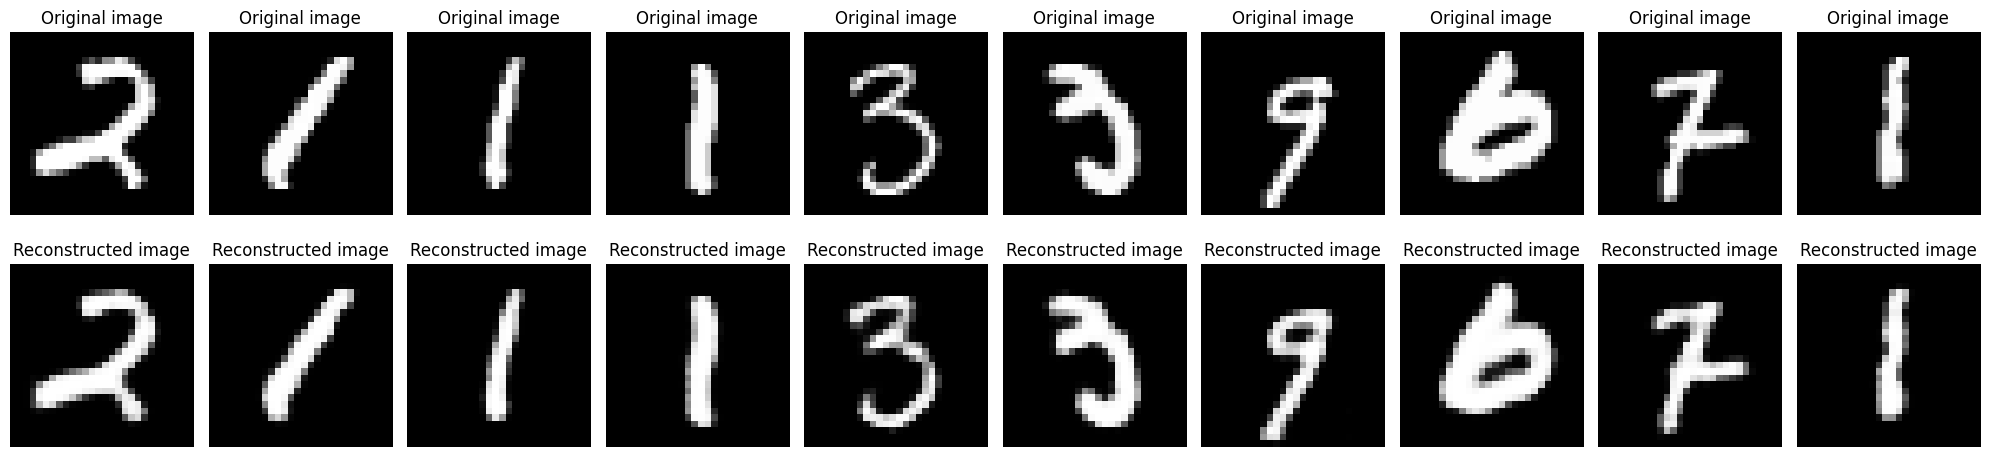

In [24]:
def plot_sample(num_sample=10):
    plt.figure(figsize=(20, 5))
    
    x_test_sample = x_test[:num_sample, :]
    
    outputs = []
    origins = []
    for i in x_test_sample:
        origins.append(i.reshape(28, 28))
    reconstructed_img_sample = model.forward(x_test_sample)
    for i in reconstructed_img_sample:
        outputs.append(i.reshape(28, 28))
    for i in range(num_sample):
        ax = plt.subplot(2, num_sample, i + 1)
        plt.title("Original image")
        plt.imshow(origins[i], cmap='gray')
        plt.axis("off")
        
        ax = plt.subplot(2, num_sample, i + 1 + num_sample)
        plt.title("Reconstructed image")
        plt.imshow(outputs[i], cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()
        
plot_sample(10)